WILMINGTON
Runs models, maps hubs in statewide vs. community partner-influenced models, compares capacities in the two model types, and outputs information about built hub types

In [40]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyomo.environ import *
import pyomo.opt as pyopt

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean, median

import itertools

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import shapely
import folium
import plotly.graph_objects as go # or plotly.express as px
import seaborn as sns

import importlib
import deployment_models_cmm
importlib.reload(deployment_models_cmm)
import solve_models_functions_cmm
importlib.reload(solve_models_functions_cmm)
from solve_models_functions_cmm import *

import plotly

import data_cleaning_cmm
importlib.reload(data_cleaning_cmm)
from data_cleaning_cmm import (blockgroup_pop_dict, blockgroup_walkability_dict, blockgroup_no_car_pop_dict, bg_ces_dict,
                               survey_distance_dict,
                               dist_to_site_wilmington_df, dist_to_site_wilmington_dict,
                               dist_to_site_wilmington_walk_df, dist_to_site_wilmington_walk_dict,
                               dist_to_site_wilmington_walk_transit_df, dist_to_site_wilmington_walk_transit_dict,
                               dist_to_site_wilmington_old_sites_df, dist_to_site_wilmington_old_sites_dict,
                           county_prop_ealp_dict, site_kw_occ_dict_wilmington,
                           site_sqft_dict, site_cost_dict_wilmington,
                              site_kw_occ_dict_48, site_cost_dict_48)
import locate_site_bgs_cmm
importlib.reload(locate_site_bgs_cmm)
from locate_site_bgs_cmm import (sites_bgs_dict, sites_bgs_dict_wilmington)

In [2]:
site_kw_occ_dict = site_kw_occ_dict_wilmington
site_cost_dict = site_cost_dict_wilmington

In [3]:
# Load sites data
ca_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4269'
wgs84 = 'EPSG:4326'

# Building candidate sites GeoDataFrame
sites_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_sites_campuses.csv')
sites_df_raw = pd.read_csv(sites_path)
sites_df_raw = sites_df_raw.loc[sites_df_raw['cat_site'] != 'X', ['id_site', 'type_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom = gpd.points_from_xy(sites_df_raw.LON, sites_df_raw.LAT, crs = nad83)
sites_gdf = gpd.GeoDataFrame(sites_df_raw, geometry = sites_geom, crs = nad83)

sites_path_wilmington = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'estimated_square_footages.csv')
sites_df_raw_wilmington = pd.read_csv(sites_path_wilmington)
sites_df_raw_wilmington["id_site"] = np.arange(len(sites_df_raw_wilmington))
sites_df_raw_wilmington = sites_df_raw_wilmington.loc[sites_df_raw_wilmington['cat_site'] != 'X', ['id_site', 'type_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom_wilmington = gpd.points_from_xy(sites_df_raw_wilmington.LON, sites_df_raw_wilmington.LAT, crs = nad83)
sites_gdf_wilmington = gpd.GeoDataFrame(sites_df_raw_wilmington, geometry = sites_geom_wilmington, crs = nad83)


In [4]:
# match sites to the walkability of the block groups they're in
for site, bg in sites_bgs_dict_wilmington.items():
    sites_bgs_dict_wilmington[site] = blockgroup_walkability_dict.get(bg)
keys_values = sites_bgs_dict_wilmington.items()
sites_bgs_dict_wilmington= {str(key): value for key, value in keys_values}
for site, bg in sites_bgs_dict.items():
    sites_bgs_dict[site] = blockgroup_walkability_dict.get(bg)

In [143]:
# change the church near Tzu Chi clinic and the Senior center to have 0 cost
#site_cost_dict['11174'] = 0 # senior center
#site_cost_dict['11186'] = 0 # Tzu Chi church

In [230]:
#for bg in list(dist_to_site_wilmington_walk_df.columns):
#    print(site_cost_dict[bg], site_kw_occ_dict[bg])

In [5]:
# Run models
# apply cost minimization combined function

max_cost = 10000000 # $ that we can spend on hubs
max_distance_walk = 1
conversion_walk_transit = 1290 # seconds/mile to convert distance matrix to miles (miles used in survey)
max_distance_drive = 1000
to_build = ['11174', '11186'] # force build of two hubs

# statewide (walking) model
#w_state = model_pop_served_max(dist_to_site_wilmington_df.copy(), max_cost, site_cost_dict, site_kw_occ_dict, max_distance_drive, [])
w_state = model_pop_served_max(dist_to_site_wilmington_old_sites_df.copy(), max_cost, site_cost_dict_48, site_kw_occ_dict_48, max_distance_drive, [])
# walking + transit, walkability, walking population, survey
w_local = model_pop_served_max_survey(scale_walkability(sites_bgs_dict_wilmington.copy(), dist_to_site_wilmington_walk_transit_df.copy()/conversion_walk_transit), 
                                                           max_cost, site_cost_dict, site_kw_occ_dict, to_build, CES = False, walk_pop = True)

#w_walk = model_pop_served_max(dist_to_site_wilmington_walk_df.copy(), max_cost, max_distance_walk, to_build)
#w_walk_survey = model_pop_served_max_survey(dist_to_site_wilmington_walk_df.copy(), max_cost, to_build)
#w_walk_walk_pop_walkability_survey = model_pop_served_max_survey(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, to_build, CES = False, walk_pop = True)
#w_walkability_ces = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, to_build, CES = True)
#w_walkability_ces_walk_pop = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, to_build, CES = True, walk_pop = True)
#w_ces_walk_pop = model_pop_served_max(dist_to_site_wilmington_df.copy(), 
#                                                           max_cost, max_distance_walk, to_build, CES = True, walk_pop = True)
#w_walkability_walk_pop = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, to_build, CES = False, walk_pop = True)
#w_walk_walkability_survey = model_pop_served_max_survey(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, to_build, CES = False, walk_pop = False)

In [28]:
#w_local[w_local['BUILT']==1]
for id_hub in list(w_local[w_local['BUILT']==1].index):
    print(site_cost_dict[id_hub])
print(w_local[w_local['BUILT']==1])

2728878.599720414
2112706.519172927
4185296.894436178
55003.784782393595
249951.06339927652
       BUILT     CAPACITY
3277       1  1545.694200
11174      1  1123.885066
11186      1  2400.559322
11188      1    29.016652
11206      1   134.296743


In [12]:
def plot_capacity(data, names, title):
    for i in np.arange(len(data)):
        data[i] = data[i].loc[data[i]['BUILT'] == 1]['CAPACITY']
    plt.hist(data, label = names, alpha = 0.5)
    plt.legend()
    plt.xlabel("Hub Capacity")
    plt.title(title)
    return plt

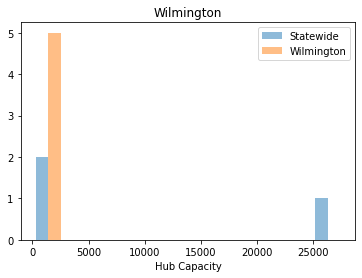

In [13]:
fig = plot_capacity([w_state, w_local],
              ["Statewide", "Wilmington"],
             "Wilmington")
fig.savefig("results/figures/fig_5c.svg")

In [34]:
def map_wilmington_hubs(hubs_yn, sites_gdf):
    sites = pd.DataFrame(columns = ['LAT', 'LON', 'Site Type'])
    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(sites_gdf, int(site), 'id_site')
        site_pt.append(sites_gdf.loc[sites_gdf['id_site'] == int(site)].values[0][2])    
        sites.loc[len(sites.index)] = site_pt
    color_map = {"CC": '#FF9252', 'W': '#B55AD6', 'SCHOOL': '#00B2CA'}
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
                           mapbox_style="carto-positron", 
                            color=sites['Site Type'], 
                            color_discrete_map=color_map,
                           center=dict(lat=33.78221706729471, 
                                     lon = -118.26113174062104),
                          zoom=13.5,
                          width=1250, height=1000,
                           title = "Local Model Recommended Sites")
    fig.show()
    return fig

In [32]:
#def map_hubs(hubs_yn, sites_gdf):
#    sites = pd.DataFrame(columns = ['LAT', 'LON'])
#    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
#    for site in hubs:
#        site_pt = locate(sites_gdf, site, 'id_site')
#        sites.loc[len(sites.index)] = site_pt
#    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
#                           mapbox_style="carto-positron", zoom=12.25, color_discrete_sequence = ["black"],
#                           center=dict(lat=33.782502446220356, 
##                                     lon = -118.26044509106327),
#                           title = "State Model Recommended Sites")
#    fig.show()
def map_hubs(hubs_yn, sites_gdf):
    sites = pd.DataFrame(columns = ['LAT', 'LON', 'Site Type'])
    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(sites_gdf, site, 'id_site')
        site_pt.append(sites_gdf.loc[sites_gdf['id_site'] == site].values[0][2])    
        sites.loc[len(sites.index)] = site_pt
    color_map = {"CC": '#FF9252', 'W': '#B55AD6', 'Pri': '#00B2CA', 'Sec': '#00B2CA'}
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
                            mapbox_style="carto-positron", 
                            #mapbox_style = "open-street-map",
                            color=sites['Site Type'], 
                            color_discrete_map=color_map,
                            center=dict(lat=33.78221706729471, 
                                     lon = -118.26113174062104),
                          zoom=13.5,
                          width=1250, height=1000,
                           title = "Recommended Sites")
    fig.show()
    return fig

In [33]:
fig = map_hubs(w_state, sites_gdf)
plotly.io.write_image(fig, 'results/figures/fig_5a.svg', format='svg', scale=1, width=1250, height=1000)

In [37]:
fig = map_wilmington_hubs(w_local, sites_gdf_wilmington)
plotly.io.write_image(fig, 'results/figures/fig_5b.svg', format='svg', scale=1, width=1250, height=1000)

In [31]:
# Load CES
CES_data = pd.read_csv("data/bg_ca_19/bg19_ces_indicators.csv")

In [32]:
local_hubs = w_local.loc[w_local['BUILT'] == 1].index
local_bg = yes_distance(local_hubs, dist_to_site_wilmington_walk_transit_df, 1*1290)
statewide_hubs = w_state.loc[w_state['BUILT'] == 1].index
statewide_bg = yes_distance(statewide_hubs, dist_to_site_wilmington_old_sites_df, 1)

In [33]:
all_bg = dist_to_site_wilmington_walk_transit_df.index

In [41]:
def histogram_characteristics(list_bg_ids, data, group_names, x_axis, characteristic):
    list_x = pd.DataFrame(columns = [characteristic, 'Key'])
    # create x values for plot
    for i in np.arange(len(list_bg_ids)):
        to_append = pd.DataFrame({characteristic: (retrieve_characteristics(list_bg_ids[i], data, characteristic)),
                              'Key': [group_names[i]]*len(list_bg_ids[i])})
        print("Mean", group_names[i], mean(to_append[characteristic]))
        print("Median", group_names[i], median(to_append[characteristic]))
        list_x = pd.concat([list_x, to_append])
    list_x.reset_index(level=0, inplace=True)
    fig = sns.kdeplot(x = list_x[characteristic],
                  hue = list_x['Key'],
                  common_norm = False)
    plt.xlabel(x_axis)
    sns.move_legend(fig, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

Mean Wilmington 0.1673357130385192
Median Wilmington 0.165016501650165
Mean Local Model 0.17554827057296649
Median Local Model 0.180678585227073
Mean Statewide Model 0.1827093115262191
Median Statewide Model 0.189526184538653


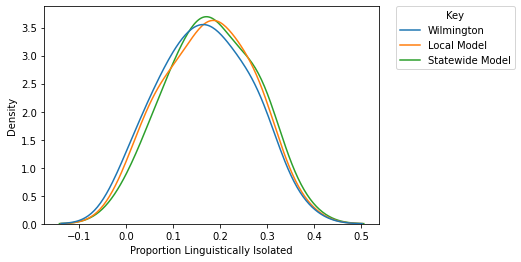

In [42]:
fig = histogram_characteristics([all_bg, local_bg, statewide_bg], CES_data, ["Wilmington", "Local Model", "Statewide Model"], "Proportion Linguistically Isolated", "PCT_LINGISO").figure
fig.savefig("results/figures/fig_6a.svg")

Mean Wilmington 73.70171428571429
Median Wilmington 76.33
Mean Local Model 74.8878125
Median Local Model 76.33
Mean Statewide Model 73.00185185185185
Median Statewide Model 76.33


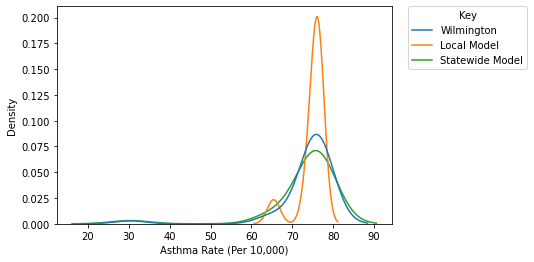

In [43]:
fig = histogram_characteristics([all_bg, local_bg, statewide_bg], CES_data, ["Wilmington", "Local Model", "Statewide Model"], "Asthma Rate (Per 10,000)", "RATE_ASTH").figure
fig.savefig("results/figures/fig_6b.svg")

In [14]:
def map_wilmington_hubs_size(hubs_yn, sites_gdf, size_cap):
    sites = pd.DataFrame(columns = ['LAT', 'LON', 'Site Type', 'Capacity'])
    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(sites_gdf, int(site), 'id_site')
        site_pt.append(sites_gdf.loc[sites_gdf['id_site'] == int(site)].values[0][2])    
        site_pt.append((site_kw_occ_dict[site]/size_cap)*40+1)
        sites.loc[len(sites.index)] = site_pt
    site_pt = [10, 10, 'C', 50] # add in extra point for consistent scaling across maps
    sites.loc[len(sites.index)] = site_pt
    color_map = {"CC": '#FF9252', 'W': '#B55AD6', 'SCHOOL': '#00B2CA'}
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
                           mapbox_style="carto-positron", 
                            color=sites['Site Type'], 
                            color_discrete_map=color_map,
                           center=dict(lat=33.78221706729471, 
                                     lon = -118.26113174062104),
                            size = sites['Capacity'],
                            size_max = max(sites['Capacity']),
                          zoom=13.5,
                          width=1250, height=1000,
                           title = "Local Model Recommended Sites")
    fig.show()
    return fig

In [21]:
def map_hubs_size(hubs_yn, sites_gdf, size_cap):
    sites = pd.DataFrame(columns = ['LAT', 'LON', 'Site Type', 'Capacity'])
    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(sites_gdf, site, 'id_site')
        site_pt.append(sites_gdf.loc[sites_gdf['id_site'] == site].values[0][2])
        site_pt.append((site_kw_occ_dict_48[site]/size_cap)*40+1)
        sites.loc[len(sites.index)] = site_pt
        #print(site_kw_occ_dict[site])
    site_pt = [10, 10, 'C', 50] # add in extra point for consistent scaling across maps
    sites.loc[len(sites.index)] = site_pt
    color_map = {"CC": '#FF9252', 'W': '#B55AD6', 'Pri': '#00B2CA', 'Sec': '#00B2CA'}
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
                            mapbox_style="carto-positron", 
                            #mapbox_style = "open-street-map",
                            size = sites['Capacity'],
                            size_max = max(sites['Capacity']),
                            color=sites['Site Type'], 
                            color_discrete_map=color_map,
                            center=dict(lat=33.78221706729471, 
                                     lon = -118.26113174062104),
                          zoom=13.5,
                          width=1250, height=1000,
                           title = "Recommended Sites")
    fig.show()
    return fig

In [16]:
fig = map_wilmington_hubs_size(w_local, sites_gdf_wilmington, 25000)
plotly.io.write_image(fig, 'results/figures/poster_1c.svg', format='svg', scale=1, width=1250, height=1000)

In [23]:
fig = map_hubs_size(w_state, sites_gdf, 25000)
plotly.io.write_image(fig, 'results/figures/poster_1d.svg', format='svg', scale=1, width=1250, height=1000)